# ICESat-2 Hackweek 2020: Machine Learning

#### Yara Mohajerani ([ymohajer@uci.edu](mailto:ymohajer@uci.edu))

**Note** Before going through this tutorial, make sure you have the correction environment by running

`conda create --name <env> --file mlenv.lock`
with the `mlenv.lock` file being in this repositoriy, and choose the this environment for your kernel.

---

In this tutorial we will explore the basics of machine learning with an emphasize on neural networks and applications in altimetry. First we will offer a brief introduction to theory and techniques in implementing neural networks, and then will focus on altimetry applications.

## Motivation
Advances in machine learning have made it a valuable tool for extracting insights from large datasets without the need for developing exact analytical algorithms. In particular, this has proven extremely useful for altimetry applications. For example, imagine you have thousands of satellite images and you want to identify paricular features automatically in the dataset. One way is to manually go through the data, which is not practical. The second way is to come up with an analytical algorithm that uses explicit engineered laws to detect the desired features. This is not very easy or robust, to say the least. But machine learning methods can learn to perform the desired task from the data in an approximate manner. Specifically, *supervised* methods use the data along with the desired outputs to accomplish the learning task. Here we will focus on supervised machine learning. An extremely useful subset of supervised machine learning fields is *neural networks*, which will be discussed in this notebook.

Given the shear volume of altimetry data from ICESat-2, the is huge potential in extracting insights from the data with machine learning that were not possible before. Keep in mind that machine learning is a big field and here we focus on only a few specific approaches and a few computational tools. Specifically, we will focus on neural networks largely implemented in `keras`.

---
Introduction to neural networks
---

Neural networks use a series of nonlinear transformations with adjustable (trainable) parameters to approximate an input field into a desired output.

Each neuron or unit of a network has an associated weight $w$ and bias $b$, and an activation function $f(z)$ for applying a nonlinear transformation such that the output is

$$
\begin{aligned}
 f(\mathbf{w}\cdot \mathbf{x} + b)
\end{aligned}
$$

for input $x$.

A neural network contains many layers of nodes to accomplish more involved transformations. Note that each unit only has one adjustable bias $b$, but each precedening connected note has a weight $w$ associated with it. All the weighted inputs are summed such that the output is

$$
\begin{aligned}
 f(b+\sum_{i} w_ix_i)
\end{aligned}
$$


![Neural network generic example fromw ww.astroml.org](https://www.astroml.org/_images/fig_neural_network_1.png)
<sub>Schematic from [AstroML](https://www.astroml.org/book_figures/chapter9/fig_neural_network.html#book-fig-chapter9-fig-neural-network)
    
    Figure produced by code under BSD license authored by Jake VanderPlas & Brigitta Sipocz.
    The figure produced by this code is published in the textbook "Statistics, Data Mining, and Machine Learning in Astronomy" (2019)
    For more information, see http://astroML.github.com

Some examples of activation functions are 
Sigmoid:

$$
\begin{aligned}
 f(z) = \frac{1}{1+e^{-z}}
\end{aligned}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

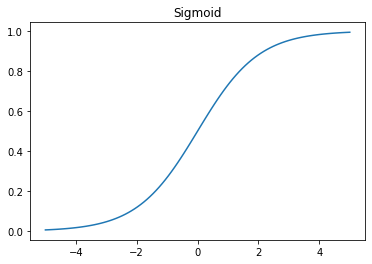

In [2]:
x = np.linspace(-5,5,100)
y = 1/(1+np.exp(-x))
plt.plot(x,y)
plt.title('Sigmoid')
plt.show()

or

Rectified Linear Unit (ReLU):

$$
\begin{aligned}
 f(z) = \max(0,z)
\end{aligned}
$$

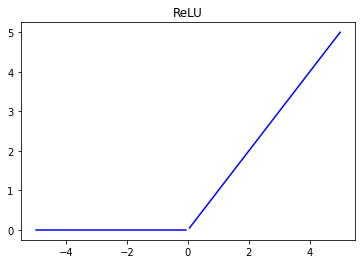

In [3]:
x = np.linspace(-5,5,100)
plt.plot(x[:50],np.zeros(50),'b-')
plt.plot(x[50:],x[50:],'b-')
plt.title('ReLU')
plt.show()

And many others, which is beyond the scope of this brief tutorial. There are many excellent resources on the choice activation functions (e.g. [Neural Networks and Deep Learning by Michael Nielson](http://neuralnetworksanddeeplearning.com/chap3.html))

---


Packages like PyTorch and TensforFlow provide the tools to contruct neural networks in Python. However, here we focus on Keras, a higher-level package which makes it easier to contruct a network.

Here as an example we will contruct a simple model for the quintessential machine learning example of identifying handwritten digits (MNIST dataset).

#### 1) Get data and develop neural network

In [4]:
#--  import required packages
import keras
from keras.datasets import mnist
from keras.layers import Dense, Activation
from keras.utils import plot_model

Using TensorFlow backend.


In [5]:
#-- Get built-in MNIST data from keras
#-- "Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.""
#-- https://keras.io/datasets/#mnist-database-of-handwritten-digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

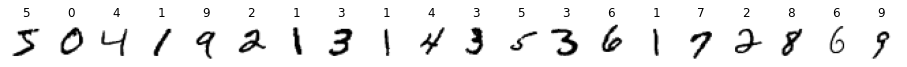

In [6]:
fig, ax = plt.subplots(1, 20, figsize=(16,5))
for i in range(20):
    ax[i].imshow(x_train[i],cmap='binary')
    ax[i].set_title(y_train[i])
    ax[i].axis('off')
plt.show()

In [7]:
#-- Turn the trainign labels (indicating which number each image is), into one-hot encoding
#-- e.g. 3 --> [0,0,0,1,0,0,0,0,0,0]
onehot_train = keras.utils.to_categorical(y_train, num_classes=10)

In [8]:
#-- Make sequential model
model = keras.Sequential()
"""Dense implements the operation: output = activation(dot(input, kernel) + bias)
https://keras.io/layers/core/"""
#-- first hidden layer has 64 units, and input is 28*28 which is the flattened input data
model.add(Dense(64, activation='relu', input_dim=x_train.shape[1]*x_train.shape[2]))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))

This is categorical classification with 10 classes (0-9), hence 10 units in the last layer. Note that the activation function for the last layer is Softmax. Softmax is a normalized exponential function that returns normalized probabilities using

$$
\begin{aligned}
 \sigma(z_i) = \frac{e^{z_i}}{\sum_{j}e^{z_j}}
\end{aligned}
$$

where $z_i$ is given by $\sum_j w_{ji}x_j + b_i$.

Thus, the neural network provides probabilities for a given input belonging to each of the 10 classes given by each of the 10 output units.

We compile the model with a `categorical_crossentropy` loss function used to train the model.

Loss functions are also beyond the scope of this short tutorial, but here `categorical_crossentropy` basically takes in onehot encoded data and calculates the cross entropy loss.

$$
\begin{aligned}
 L = -\sum_{c=0}^{M}y_c\log p_c 
\end{aligned}
$$

Where $y_c$ is the truth label for categoriy $c$ (either 0 or 1) and $p_c$ is the prediction for category $c$ (probability between 0 and 1). $M$ is the total number of classes, which is 10 here.

In [9]:
model.compile(optimizer='adam',     # optimization algorithm used (other examples include scholastic gradient descent, etc)
              loss='categorical_crossentropy',
              metrics=['accuracy']) # quantity to be minimized

Next we can train the model using the `fit` function. Note that we flatten the input images as specified by the input layer when defining our model. `batch_size` refers to the number of images used in each training iteration (every step/iteration that we update the parameters based on the loss function using the optimizer), and `epoch` is total number of times the whole dataset is used. So total number of iterations is `total_size/batch_size * epochs`.

We also want to save our model as we train it. One powerfull tool is to create `callbacks` that save the model in after each epoch under specified conditions (for example only saving the best case or all). There are other very useful `callbacks` such as reducing the learning step when we reach a plateau, etc. Here we will just create a model checkpoint to save the progress:

In [10]:
chk_file = 'mnist_model.h5'
#-- create checkpoints that only saves the best trained network so far based on the loss value.
model_checkpoint = keras.callbacks.ModelCheckpoint(chk_file, monitor='loss',
                                                     verbose=1, 
                                                     save_best_only=True)

Now train the model and pass the checkpoint as a callback.

In [11]:
#-- Train model
#-- We will just use 5 epochs to save time, with batch sizes of 32
model.fit(x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2]),
          onehot_train, epochs=5, batch_size=32, callbacks=[model_checkpoint])

Epoch 1/5
60000/60000 [==============================] - 65s 1ms/step - loss: 1.9909 - accuracy: 0.8357

Epoch 00001: loss improved from inf to 1.99090, saving model to mnist_model.h5
Epoch 2/5
60000/60000 [==============================] - 52s 862us/step - loss: 0.3734 - accuracy: 0.9114

Epoch 00002: loss improved from 1.99090 to 0.37339, saving model to mnist_model.h5
Epoch 3/5
60000/60000 [==============================] - 27s 457us/step - loss: 0.2731 - accuracy: 0.9310

Epoch 00003: loss improved from 0.37339 to 0.27311, saving model to mnist_model.h5
Epoch 4/5
60000/60000 [==============================] - 29s 482us/step - loss: 0.2230 - accuracy: 0.9412

Epoch 00004: loss improved from 0.27311 to 0.22305, saving model to mnist_model.h5
Epoch 5/5
60000/60000 [==============================] - 31s 512us/step - loss: 0.1956 - accuracy: 0.9489

Epoch 00005: loss improved from 0.22305 to 0.19559, saving model to mnist_model.h5


#### 2) Evaluate model

In [12]:
#-- turn testing labels to one-hot encoded
onehot_test = keras.utils.to_categorical(y_test, num_classes=10)
#-- evaluate performance of model
#-- Returns the loss value & metrics value, which in this case is accuracy
model.evaluate(x=x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2]),
               y=onehot_test, verbose=1)

10000/10000 [==============================] - 3s 296us/step


[0.2150905791155994, 0.9484999775886536]

The evaluation output has multiple components. The first is always the loss function, and the remaining elements are the metrics specified in the `compile` command, which in this case is just `accuracy`. We see that even with just 5 epochs we get very good accuracy.

---

Note we could have also just saved the model after it was trained:

In [13]:
model.save("mnist_model_saveAgain.h5")

If you have a saved file, you can also load it the weights just as easily:

In [14]:
# model.load_weights("model.h5")

---
# Regression Exercise with Neural Networks with ATL03-like data
---
Before breaking into groups, we will do the set up of the problem together.

The goal is to now do a regerssion problem. You will have to figure out a way to alter the architecture of the neural network to provide an output that is not a set of classifications, but a regression parameter.

First we will create simulated ATL03 data by creating a noisy dataset of a series of patches with linear features and Gaussian noise.

In [15]:
#-- create 2000 line segments in tiles with width 40 and add Guassian noise
n_tiles = 2000
w = 40
pts = 30 # number of poits to sample
repeat = 3 # number of times to repeat the noise addition at each coordinate

# Fixing random state for reproducibility
np.random.seed(13)

#-- training data has dimensions: # of tilesm, # of points, 2 for the x,y coords of points
coords = np.empty((n_tiles,pts*repeat,2),dtype=float)
#-- we choose a random slope and intercept in the range -4 to 4 for both, with uniform distribution
params = np.random.uniform(-4,4,(n_tiles,2))

#-- Now populate x with noisy data
#-- to make the data more similar to ATL03, we will have multiple y values for each x value
for i in range(n_tiles):
    #-- create line 
    line = params[i,0] + np.arange(w)*params[i,1] + np.random.normal(loc=0,scale=5,size=w)
    #-- randomly select `pts` number of points
    inds = np.random.randint(0,high=w,size=pts)
    for r in range(repeat):
        coords[i,r*pts:(r+1)*pts,0] = inds
        # Add Gaussian noise with standard deviation 10
        coords[i,r*pts:(r+1)*pts,1] = line[inds] + np.random.normal(loc=0,scale=10,size=pts)

In [16]:
#-- Separate 10% of elements for testing
#-- randomly extract indices for 10% of elements
ii = np.random.randint(0,high=n_tiles,size=int(n_tiles*0.1))
x_test = coords[ii]
y_test = params[ii]
#-- set the rest for training by getting difference between union and intersection
jj = np.setdiff1d(np.union1d(np.arange(n_tiles), ii), np.intersect1d(np.arange(n_tiles), ii))
x_train = coords[jj]
y_train = params[jj]
#-- make sure there are no overlapping elements
np.intersect1d(ii,jj)

array([], dtype=int64)

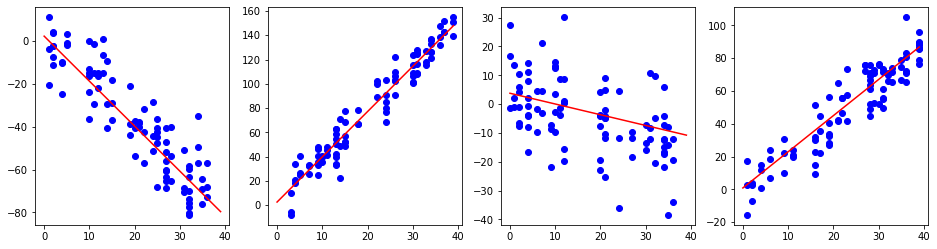

In [17]:
#-- Plot some example tiles
fig,ax = plt.subplots(1, 4,figsize=(16,4))
#-- loop over to plot the first 4 tiles
for i in range(4):
    ax[i].plot(coords[i,:,0],coords[i,:,1],'bo')
    ax[i].plot(np.arange(w),params[i,0] + np.arange(w)*params[i,1],'r-')
plt.show()

# Breakout (8 minutes)
Try to create a neural network that learn from the examples above and get the slope and coefficient for a given linear feature.

**HINT** You can use a series of Dense layers as before to find an approximate mapping between input and outputs. However, note that since we want to output regression values here, instead of a `softmax` activation, simply use the `linear` activation to preserve the output of the last layer instead of mapping the output to probability space.



---
### My Solution:

In [18]:
model2 = keras.Sequential()

model2.add(Dense(128, activation='relu', input_dim=coords.shape[1]*coords.shape[2]))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(256, activation='relu'))
#-- for final model we use a simple linear activation, which simply returns the input unmodified
model2.add(Dense(2, activation='linear'))

#-- we use a mean absolute error as the loss function
model2.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               23168     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 514       
Total params: 122,498
Trainable params: 122,498
Non-trainable params: 0
_________________________________________________________________


As a side note, in addition to summarizing the model as above, we can also plot it. This is particularly useful as models get larger and more complex with less linear architectures such as skip-connections, parallel layers, etc. that are outside of the scope of this tutorial.

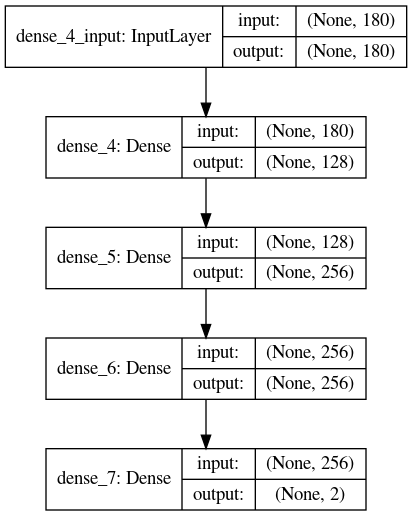

In [19]:
plot_model(model2,show_shapes=True)

In [20]:
model_checkpoint = keras.callbacks.ModelCheckpoint('regression_model.h5', monitor='loss',
                                                     verbose=1, 
                                                     save_best_only=True)

#-- Train model
model2.fit(x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2]),\
          y_train, epochs=30, batch_size=30, callbacks=[model_checkpoint])

Epoch 1/30
1814/1814 [==============================] - 2s 1ms/step - loss: 43.3460 - accuracy: 0.5524

Epoch 00001: loss improved from inf to 43.34601, saving model to regression_model.h5
Epoch 2/30
1814/1814 [==============================] - 1s 336us/step - loss: 6.1098 - accuracy: 0.6279

Epoch 00002: loss improved from 43.34601 to 6.10980, saving model to regression_model.h5
Epoch 3/30
1814/1814 [==============================] - 1s 536us/step - loss: 4.0003 - accuracy: 0.6847

Epoch 00003: loss improved from 6.10980 to 4.00028, saving model to regression_model.h5
Epoch 4/30
1814/1814 [==============================] - 2s 862us/step - loss: 3.0619 - accuracy: 0.7089

Epoch 00004: loss improved from 4.00028 to 3.06191, saving model to regression_model.h5
Epoch 5/30
1814/1814 [==============================] - 2s 1ms/step - loss: 2.4893 - accuracy: 0.7293

Epoch 00005: loss improved from 3.06191 to 2.48933, saving model to regression_model.h5
Epoch 6/30
1814/1814 [==================

In [21]:
#-- evaluate on test data
model2.evaluate(x=x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2]), y=y_test, verbose=1)

200/200 [==============================] - 0s 785us/step


[4.70385368347168, 0.6549999713897705]

In [22]:
#-- Also evaluate on train data
model2.evaluate(x=x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2]), y=y_train, verbose=1)

1814/1814 [==============================] - 0s 223us/step


[0.3973665558779253, 0.9117971062660217]

We see that the network is able to recover the regression coefficients with high accuracy for the train data and reasonable accuracy for the test data.